# Proyecto IA - Aprendizaje por Refuerzo
---

## Integrantes
- Andrés Francisco García Rivero
- Jorge Muñoz Rodríguez

### Apartado 1: Implementación mediante Q-Learning

In [274]:
import numpy as np
import mdptoolbox.mdp as mdp
import matplotlib.pyplot as plt

In [275]:
# Leer el mapa
def lee_mapa(fichero):
    with open(fichero,'r') as archivo:
        lineas = archivo.readlines()
    numeros = [float(numero) for numero in lineas[0].split()]
    lineas.pop(0)
    lineas.reverse()
    matriz = []
    for linea in lineas:
        fila = [int(caracter) for caracter in linea.strip()]
        matriz.append(fila)
    return np.array(matriz),(int(numeros[0]),int(numeros[1]))

mapa,destino = lee_mapa("map.txt")

In [276]:
# Parámetros del entorno
m,n = mapa.shape
Perror = 0.1  # Probabilidad de error en el movimiento
print("Mapa de tamaño",m,"filas x",n,"columnas")

Mapa de tamaño 15 filas x 51 columnas


In [277]:
# Posiciones inicial y final
def inicializa_posicion(mapa, destino):
    inicio = np.random.randint(n), np.random.randint(m)
    intentos = 0
    max_intentos = 1000
    while mapa[inicio[1],inicio[0]] == 1 or inicio == destino:
        inicio = np.random.randint(n), np.random.randint(m)
        intentos += 1
        if intentos > max_intentos:
            raise ValueError("No se pudo encontrar una posición inicial válida.")
    return inicio

inicio = inicializa_posicion(mapa, destino)
print(inicio)
print(destino)

(36, 2)
(40, 7)


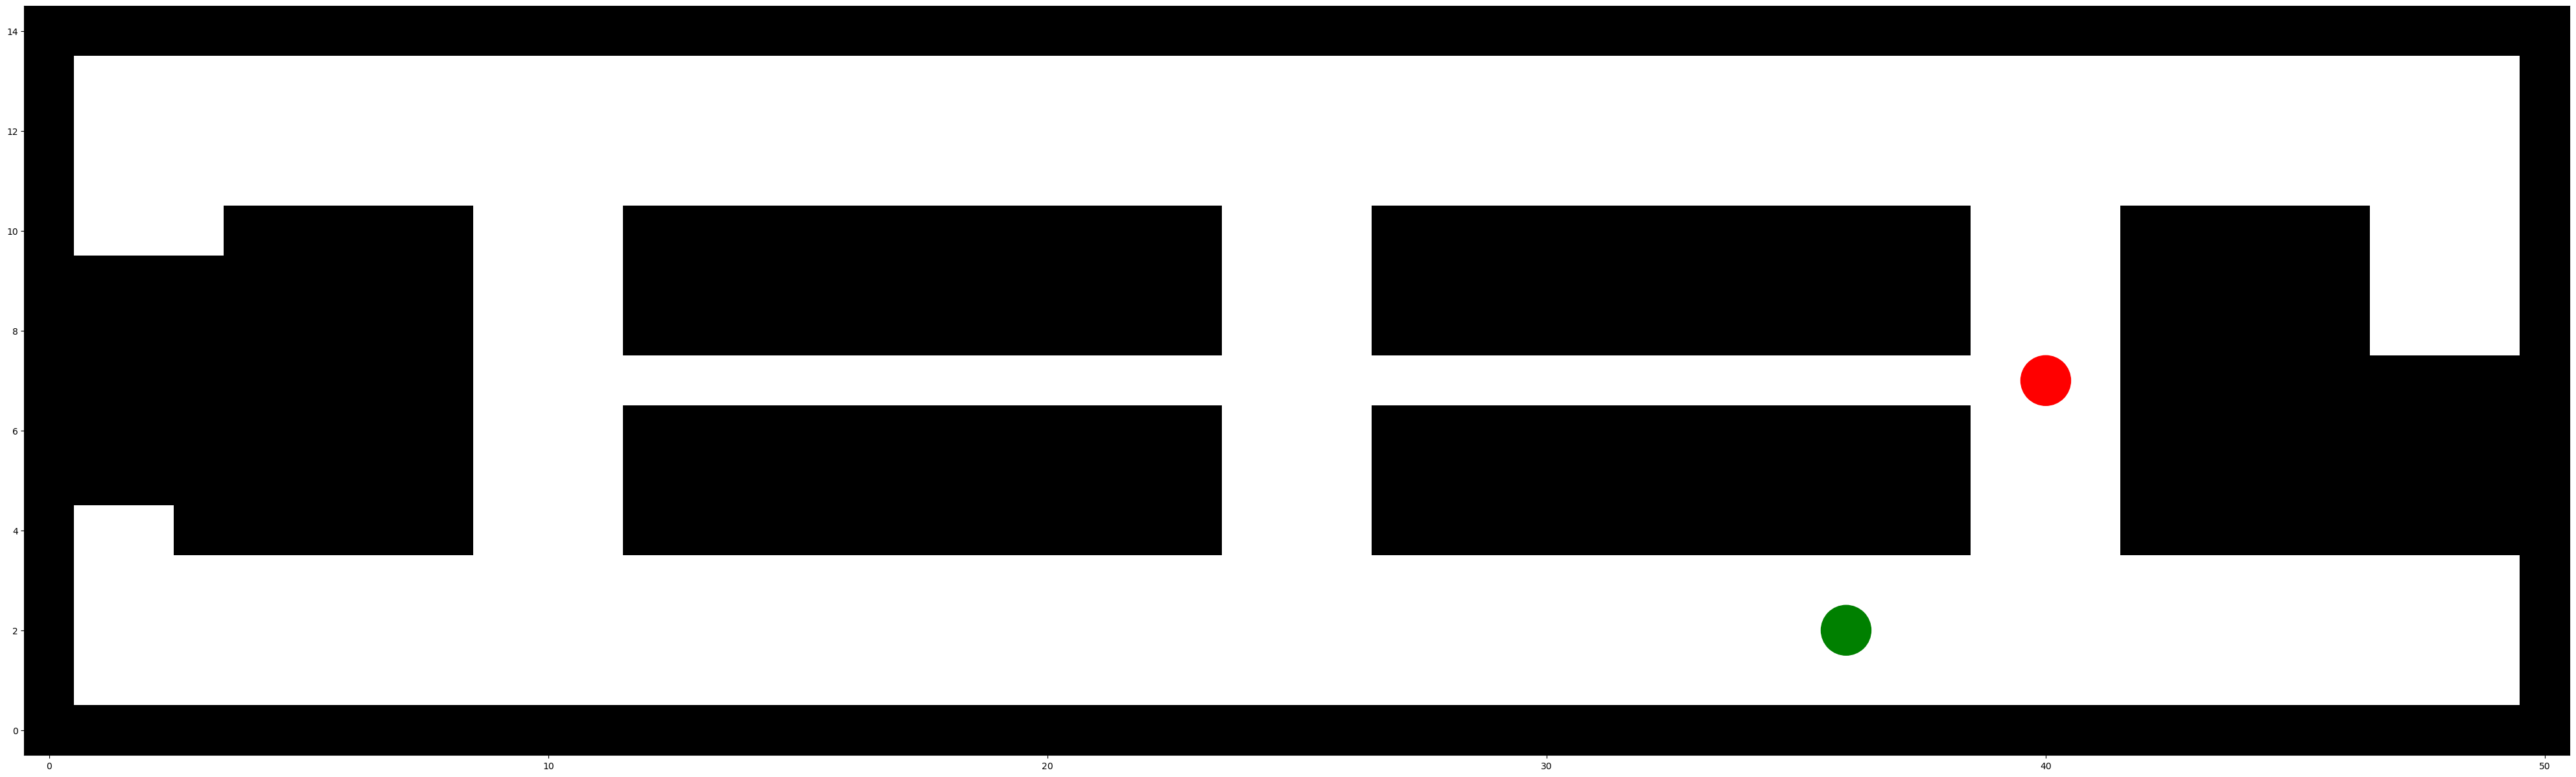

In [278]:
def visualiza_mapa():
    plt.figure(figsize=(len(mapa[0]), len(mapa)))
    plt.imshow(1-mapa, cmap='gray', interpolation='none')
    plt.xlim(-0.5, len(mapa[0]) - 0.5)
    plt.ylim(-0.5, len(mapa) - 0.5)
    plt.gca().add_patch(plt.Circle(destino,radius = 0.5,edgecolor = 'red', facecolor = 'red'))
    plt.gca().add_patch(plt.Circle(inicio,radius = 0.5,edgecolor = 'green', facecolor = 'green'))

visualiza_mapa()

In [279]:
mapa.shape

(15, 51)

In [280]:
movimientos = {
    'wait': (0, 0), 'N': (0, 1), 'NE': (1, 1), 'E': (1, 0),
    'SE': (1, -1), 'S': (0, -1), 'SO': (-1, -1), 'O': (-1, 0), 'NO': (-1, 1)
}

# Verificar si hay colisión
def hay_colision(estado):
    return mapa[estado[1],estado[0]] == 1

def aplica_accion(estado, accion):
    if hay_colision(estado):
        return estado
    x = estado[0] + movimientos[accion][0]
    y = estado[1] + movimientos[accion][1]
    if x < 1 or x >= mapa.shape[1]-1 or y < 1 or y >= mapa.shape[0]-1 or hay_colision((x, y)):
        return estado
    return x, y

In [281]:
aplica_accion((1,1), 'S')

(1, 1)

In [282]:
# Función de recompensa
K2 = -1000

def obtiene_recompensa(estado, accion):
    nuevo_estado = aplica_accion(estado, accion)
    if hay_colision(nuevo_estado):
        return K2
    if accion == 'wait' and estado != destino:
        return -100000  # Penalizar fuertemente la acción "wait" fuera del destino
    return -np.sqrt((nuevo_estado[0] - destino[0])**2 + (nuevo_estado[1] - destino[1])**2)

In [283]:

nav_estados = [(i, j) for i in range(n) for j in range(m)]
nav_acciones = ['wait','N','NE','E','SE','S','SO','O','NO']

In [284]:
nav_estados

[(0, 0),
 (0, 1),
 (0, 2),
 (0, 3),
 (0, 4),
 (0, 5),
 (0, 6),
 (0, 7),
 (0, 8),
 (0, 9),
 (0, 10),
 (0, 11),
 (0, 12),
 (0, 13),
 (0, 14),
 (1, 0),
 (1, 1),
 (1, 2),
 (1, 3),
 (1, 4),
 (1, 5),
 (1, 6),
 (1, 7),
 (1, 8),
 (1, 9),
 (1, 10),
 (1, 11),
 (1, 12),
 (1, 13),
 (1, 14),
 (2, 0),
 (2, 1),
 (2, 2),
 (2, 3),
 (2, 4),
 (2, 5),
 (2, 6),
 (2, 7),
 (2, 8),
 (2, 9),
 (2, 10),
 (2, 11),
 (2, 12),
 (2, 13),
 (2, 14),
 (3, 0),
 (3, 1),
 (3, 2),
 (3, 3),
 (3, 4),
 (3, 5),
 (3, 6),
 (3, 7),
 (3, 8),
 (3, 9),
 (3, 10),
 (3, 11),
 (3, 12),
 (3, 13),
 (3, 14),
 (4, 0),
 (4, 1),
 (4, 2),
 (4, 3),
 (4, 4),
 (4, 5),
 (4, 6),
 (4, 7),
 (4, 8),
 (4, 9),
 (4, 10),
 (4, 11),
 (4, 12),
 (4, 13),
 (4, 14),
 (5, 0),
 (5, 1),
 (5, 2),
 (5, 3),
 (5, 4),
 (5, 5),
 (5, 6),
 (5, 7),
 (5, 8),
 (5, 9),
 (5, 10),
 (5, 11),
 (5, 12),
 (5, 13),
 (5, 14),
 (6, 0),
 (6, 1),
 (6, 2),
 (6, 3),
 (6, 4),
 (6, 5),
 (6, 6),
 (6, 7),
 (6, 8),
 (6, 9),
 (6, 10),
 (6, 11),
 (6, 12),
 (6, 13),
 (6, 14),
 (7, 0),
 (7, 1),
 (

In [285]:
# def visualiza_recompensas():
#     visualiza_mapa()
#     recompensas = [obtiene_recompensa(e) for e in nav_estados]
#     recompensas = [np.nan if elemento == K2 else elemento for elemento in recompensas]
#     max_recompensa = np.nanmax(recompensas)
#     min_recompensa = np.nanmin(recompensas)
#     for e in nav_estados:
#         r = obtiene_recompensa(e)
#         if r == K2:
#             continue
#         a = (r-min_recompensa)/(max_recompensa-min_recompensa)
#         rect = plt.Rectangle((e[0] - 0.5, e[1] - 0.5), 1, 1, alpha = a,linewidth=1, edgecolor='blue', facecolor='blue')
#         plt.gca().add_patch(rect)

# visualiza_recompensas()

In [286]:

def crea_recompensas_sistema():
    matriz = []
    for e in nav_estados:
        fila = [obtiene_recompensa(e, accion) for accion in nav_acciones]
        matriz.append(fila)
    return np.array(matriz)

nav_recompensas_sistema = crea_recompensas_sistema()


In [287]:
nav_estados.index((40,7))

607

In [288]:
#Fila 1
nav_recompensas_sistema.shape
nav_recompensas_sistema[607]

array([-0.        , -1.        , -1.41421356, -1.        , -1.41421356,
       -1.        , -1.41421356, -1.        , -1.41421356])

In [289]:
def obtiene_indice_estado(estado):
    return int(estado[0]*mapa.shape[0]+estado[1])

In [290]:
def obtiene_posibles_errores(accion):
    errores_dict = {
        'N': ['NE', 'NO'], 'S': ['SE', 'SO'], 'E': ['NE', 'SE'], 'O': ['NO', 'SO'],
        'NE': ['N', 'E'], 'NO': ['N', 'O'], 'SE': ['S', 'E'], 'SO': ['S', 'O']
    }
    return errores_dict.get(accion, [])

In [291]:
def crea_transiciones_movimiento(accion, prob_error):
    matriz = []
    for e0 in nav_estados:
        fila = [0] * len(nav_estados)
        if hay_colision(e0):
            fila[obtiene_indice_estado(e0)] = 1
        else:
            goal = aplica_accion(e0, accion)
            if prob_error == 0:
                fila[obtiene_indice_estado(goal)] = 1
            else:
                errores = obtiene_posibles_errores(accion)
                fila[obtiene_indice_estado(goal)] = 1 - prob_error
                for error in errores:
                    goal_error = aplica_accion(e0, error)
                    fila[obtiene_indice_estado(goal_error)] += prob_error / len(errores)
        suma_fila = sum(fila)
        if suma_fila != 1:
            fila = [x / suma_fila for x in fila]
        matriz.append(fila)
    return np.array(matriz)


In [292]:
def crea_transiciones_sistema(prob_error):
    return np.array([crea_transiciones_movimiento(accion, prob_error) for accion in nav_acciones])

nav_transiciones_sistema = crea_transiciones_sistema(Perror)

In [293]:
# Método para visualizar el mapa con la política óptima
def visualiza_mapa_con_politica_flechas(politica, mapa, destino, inicio):
    # Configuración de la visualización del mapa
    plt.figure(figsize=(20, 20))
    plt.imshow(1-mapa, cmap='gray', origin='lower')

    # Dibujar el destino y la posición inicial
    plt.gca().add_patch(plt.Circle(destino, radius=0.3, edgecolor='red', facecolor='red', label='Destino'))
    plt.gca().add_patch(plt.Circle(inicio, radius=0.3, edgecolor='green', facecolor='green', label='Inicio'))

    # Dibujar las políticas
    for i in range(n):
        for j in range(m):
            if mapa[j,i] == 0:  # Solo dibujar en celdas sin obstáculos
                s_index = i * m + j
                accion = nav_acciones[politica[s_index]]
                if accion == 'wait':
                    print(f"Esperar en {i, j}")
                    plt.gca().add_patch(plt.Circle((i, j), radius=0.2, edgecolor='blue', facecolor='blue'))
                else:
                    estado = (i, j)
                    e1 = aplica_accion(estado, accion)
                    x0, y0 = estado[0], estado[1]
                    x1, y1 = e1[0], e1[1]
                    plt.arrow(x0, y0, x1 - x0, y1 - y0, head_width=0.3, head_length=0.3, fc='white', ec='green')

    # Añadir leyenda y mostrar el mapa
    plt.legend(handles=[
        plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markersize=10, label='Destino'),
        plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='green', markersize=10, label='Inicio'),
        plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='blue', markersize=10, label='Wait'),
    ])
    plt.show()

In [294]:
# Método para visualizar el mapa con la política óptima
def visualiza_mapa_con_politica_letras(politica, mapa, destino, inicio):
    plt.figure(figsize=(20, 20))
    plt.imshow(1 - mapa, cmap='gray', origin='lower')

    # Dibujar el destino y la posición inicial con las coordenadas ajustadas si es necesario
    plt.gca().add_patch(plt.Circle(destino, radius=0.3, edgecolor='red', facecolor='red', label='Destino'))
    plt.gca().add_patch(plt.Circle(inicio, radius=0.3, edgecolor='green', facecolor='green', label='Inicio'))

    # Dibujar las políticas
    for i in range(n):
        for j in range(m):
            if mapa[j, i] == 0:  # Ajuste a la indexación correcta si es necesario
                s_index = i * m + j
                accion = nav_acciones[politica[s_index]]
                if accion == 'wait':
                    print(f"Esperar en {i, j}")
                    plt.text(i, j, 'WAIT', ha='center', va='center', color='blue', fontsize=12)
                else:
                    plt.text(i, j, accion, ha='center', va='center', color='brown', fontsize=12)

    plt.legend(handles=[
        plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markersize=10, label='Destino'),
        plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='green', markersize=10, label='Inicio'),
        plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='blue', markersize=10, label='Wait'),
    ])
    plt.show()

Esperar en (40, 7)


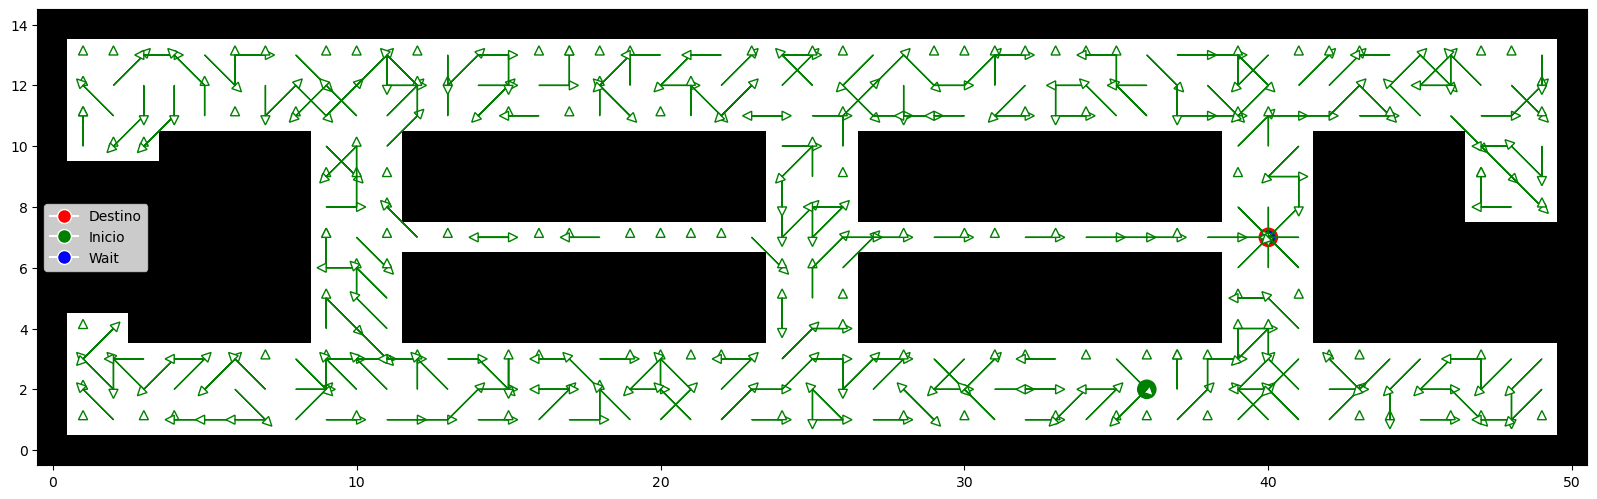

Esperar en (40, 7)


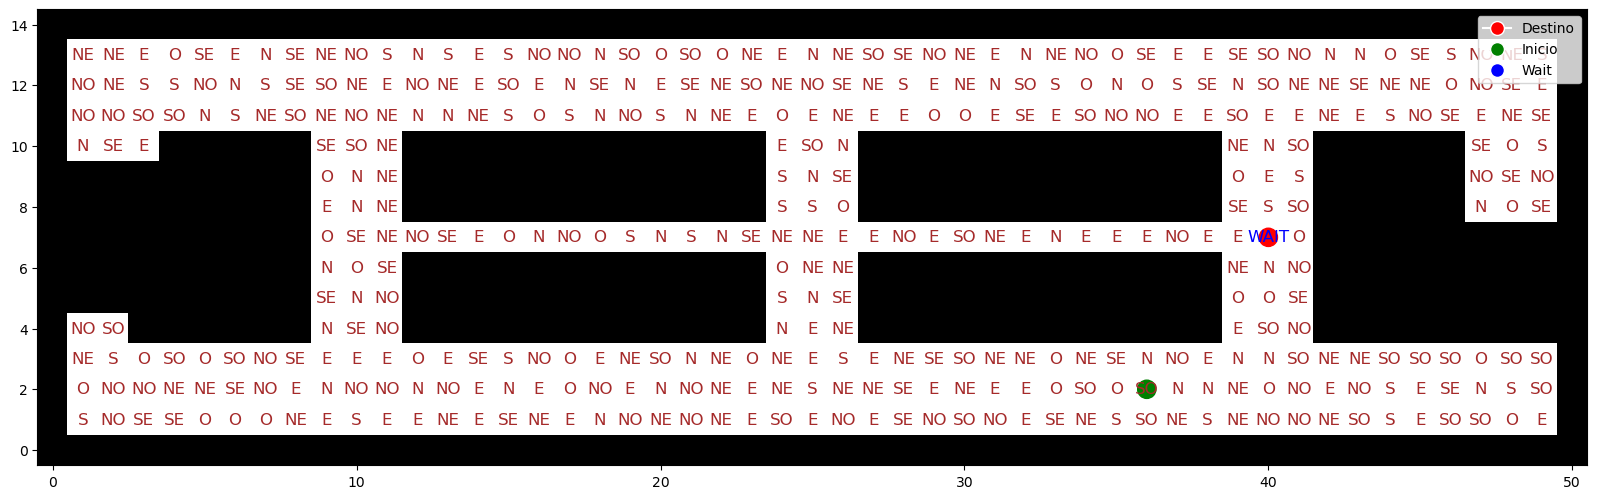

In [297]:
# Implementación de Q-Learning con mdptoolbox
ql = mdp.QLearning(nav_transiciones_sistema, nav_recompensas_sistema, discount=0.70, n_iter=500000)
ql.run()
visualiza_mapa_con_politica_flechas(ql.policy, mapa, destino, inicio)
visualiza_mapa_con_politica_letras(ql.policy, mapa, destino, inicio)